# Plotting vector polygon data of Europe with GeoPandas and Matplotlib

Data used:

- <https://www.naturalearthdata.com/downloads/10m-cultural-vectors>

Install the following packages:

- cartopy
- geopandas
- scipy
- pooch
- mapclassify
- contextily

In [1]:
import os
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import pooch
from matplotlib import patheffects
import numpy as np
import matplotlib.patches as mpatches
# import contextily as cx
import shapely
import cartopy.feature as cfeature

In [2]:
# # basemap cache directory
# cx.set_cache_dir(os.path.join("data", "basemaps"))

## Data

In [3]:
FILE_NAME = "ne_10m_admin_0_countries.zip"
URL = "https://naciscdn.org/naturalearth/10m/cultural/" + FILE_NAME
SUB_DIR = os.path.join("data", "naturalearth")
DATA_FILE = os.path.join(SUB_DIR, FILE_NAME)
os.makedirs(SUB_DIR, exist_ok=True)

In [4]:
# download data if necessary
if not os.path.isfile(os.path.join(SUB_DIR, FILE_NAME)):
    pooch.retrieve(
        url=URL, known_hash=None, fname=FILE_NAME, path=SUB_DIR
    )

In [5]:
ne = gpd.read_file(f"zip://{DATA_FILE}!{FILE_NAME[:-4]}.shp")

In [6]:
ne.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# keep European countries only and clip to extent
ne = ne[(ne["CONTINENT"] == "Europe") & (ne["TYPE"].isin(["Country", "Sovereign country"]))]
ne = ne.dissolve(by=["SOVEREIGNT"])
ne.reset_index(inplace=True)
ne = gpd.clip(ne, mask=(-25, 34, 62, 72))

In [8]:
# reproject to a projected CRS for plotting
# see https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
# for more projections
ne.to_crs(ccrs.TransverseMercator(), inplace=True)

In [9]:
ne.crs

<Projected CRS: +proj=tmerc +ellps=WGS84 +lon_0=0.0 +lat_0=0.0 +k= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# generate some random data (with a missing entry) for the choropleth map
ne["RAND"] = np.random.default_rng(seed=99).integers(low=-20, high=20, size=len(ne))
ne.loc[34, "RAND"] = np.nan

In [11]:
# keep only necessary columns
ne = ne[["NAME_LONG", "ISO_A2_EH", "RAND", "geometry"]]

In [12]:
ne

,NAME_LONG,ISO_A2_EH,RAND,geometry
29,Norway,NO,18.0,"MULTIPOLYGON (((319044.822 6569821.973, 319582..."
23,Malta,MT,0.0,"MULTIPOLYGON (((1319612.075 4070640.078, 13203..."
18,Italy,IT,10.0,"MULTIPOLYGON (((1076712.267 4136007.456, 10735..."
43,Vatican,VA,2.0,"POLYGON ((1034162.345 4716527.422, 1034122.838..."
26,Montenegro,ME,-13.0,"POLYGON ((1524449.012 4866945.386, 1524190.339..."
5,Bosnia and Herzegovina,BA,0.0,"POLYGON ((1443417.413 4904487.951, 1443371.540..."
35,San Marino,SM,17.0,"POLYGON ((998986.590 4937562.298, 996395.750 4..."
7,Croatia,HR,18.0,"MULTIPOLYGON (((1237387.658 4966767.417, 12400..."
37,Slovenia,SI,18.0,"POLYGON ((1066835.674 5127395.090, 1066827.517..."
15,Hungary,HU,4.0,"POLYGON ((1703222.069 5571544.906, 1702453.241..."


## Plot

### Using colorbar of absolute values

In [13]:
# map extent
minx, miny, maxx, maxy = gpd.GeoSeries(
    shapely.geometry.box(-15, 33, 31, 72), crs=4326
).to_crs(ccrs.TransverseMercator()).total_bounds

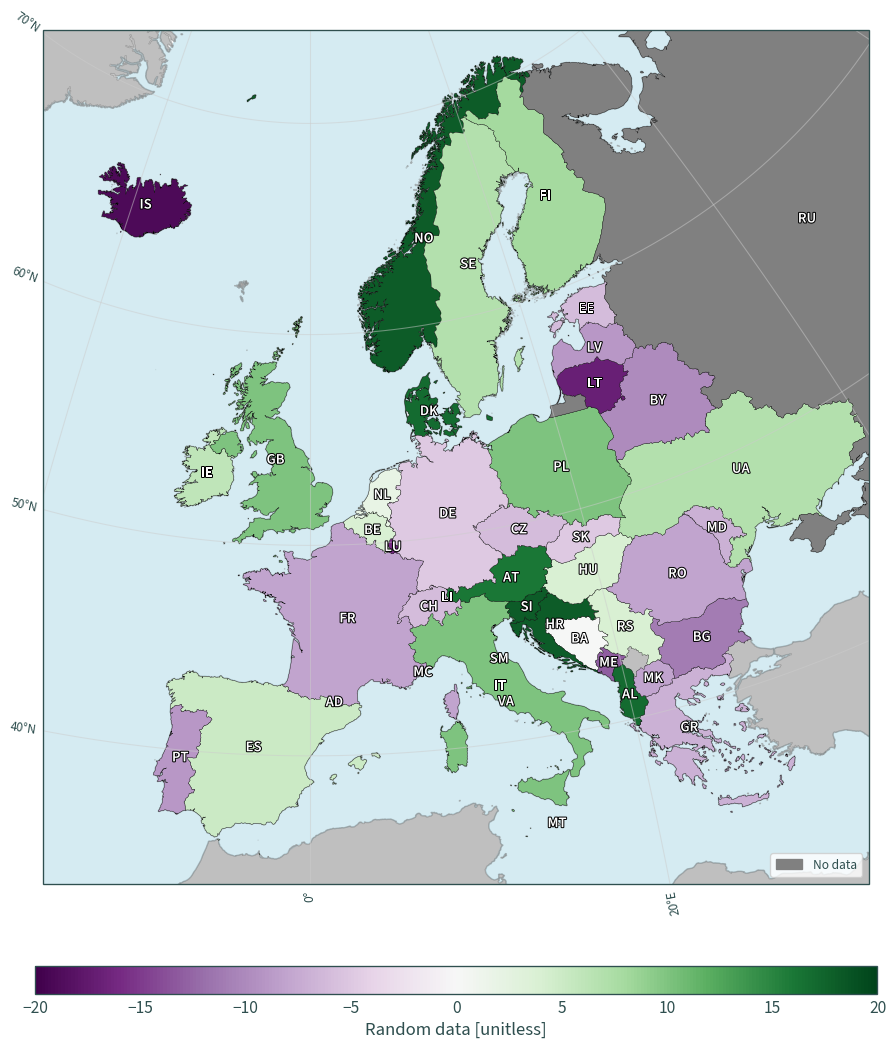

In [14]:
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.TransverseMercator())

# specify the numeric data to plot in the column keyword
# see here for colourmaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
ne.plot(
    edgecolor="black",
    linewidth=0.25,
    column="RAND",
    legend=True,
    cmap="PRGn",
    legend_kwds={
        "label": "Random data [unitless]",
        "orientation": "horizontal",
        "shrink": 0.75, "pad": 0.075, "aspect": 30,
    },
    vmax=20,  # colourbar max value
    vmin=-20,  # colourbar min value
    missing_kwds={"color": "grey",},
    ax=ax,
)

# map extent
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

# if you have entries with missing data, configure missing_kwds above and
# include the following legend
ax.legend(handles=[mpatches.Patch(color="grey", label="No data")], loc="lower right")

# optionally add labels directly to the map
# country codes used here as an example
map_labels = zip(zip(ne.centroid.x, ne.centroid.y), ne["ISO_A2_EH"])
for xy, lab in map_labels:
    ax.annotate(
        text=lab, xy=xy, rotation=0, va="center", ha="center",
        path_effects=[patheffects.withStroke(linewidth=1.5, foreground="black")],
        fontweight="semibold", fontsize=11, color="white"
    )

# optionally add gridlines
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=0.5)

# optionally add a basemap
# https://contextily.readthedocs.io/en/latest/
# cx.add_basemap(
#     ax, source=cx.providers.CartoDB.PositronNoLabels,
#     crs=ccrs.TransverseMercator(), zoom=5
# )
ax.add_feature(cfeature.OCEAN, color="lightblue", alpha=0.5)
ax.add_feature(cfeature.LAND.with_scale("10m"), color="grey", alpha=0.5)

plt.title(None)
plt.tight_layout()
plt.show()

### Using classification

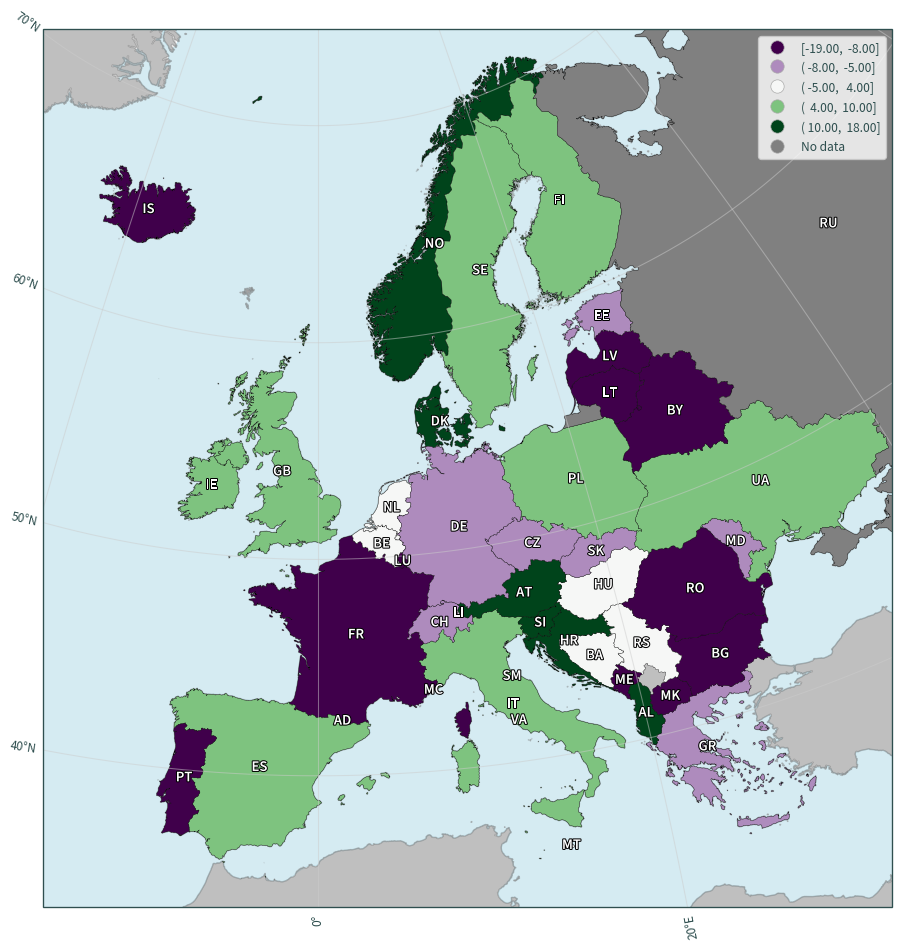

In [15]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

# specify the numeric data to plot in the column keyword
# see here for colourmaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
# see here for classification methods
# https://geopandas.org/en/stable/docs/user_guide/mapping.html#choosing-colors
ne.plot(
    edgecolor="black",
    linewidth=0.25,
    column="RAND",
    legend=True,
    legend_kwds={"interval": True},
    cmap="PRGn",
    missing_kwds={"color": "grey", "label": "No data"},
    ax=ax,
    scheme="quantiles",
)

# map extent
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

for legend_handle in ax.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(0.5)
    legend_handle.set_markeredgecolor("darkgrey")

# optionally add labels directly to the map
# country codes used here as an example
map_labels = zip(zip(ne.centroid.x, ne.centroid.y), ne["ISO_A2_EH"])
for xy, lab in map_labels:
    ax.annotate(
        text=lab, xy=xy, rotation=0, va="center", ha="center",
        path_effects=[patheffects.withStroke(linewidth=1.5, foreground="black")],
        fontweight="semibold", fontsize=11, color="white"
    )

# optionally add gridlines
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=0.5)

# optionally add a basemap
# https://contextily.readthedocs.io/en/latest/
# cx.add_basemap(
#     ax, source=cx.providers.CartoDB.PositronNoLabels,
#     crs=ccrs.TransverseMercator(), zoom=5
# )
ax.add_feature(cfeature.OCEAN, color="lightblue", alpha=0.5)
ax.add_feature(cfeature.LAND.with_scale("10m"), color="grey", alpha=0.5)

plt.title(None)
plt.tight_layout()
plt.show()